<a href="https://colab.research.google.com/github/carlomagnani/Stock-Price-Forecaster/blob/main/SP500_Trend_Forecast_may4th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

print("Tensorflow version: "+tf.__version__)

#! pip install pmdarima

# Google file system
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

drive.mount('/GoogleDrive', force_remount=True)

import math

Tensorflow version: 2.8.0
Mounted at /GoogleDrive


In [2]:
file =   "/GoogleDrive/My Drive/S&P.xlsx"
dataset = pd.read_excel(file, sheet_name="ts")

#Date to Datetime for Plotting
dataset['date'] = pd.to_datetime(dataset['date'])

#Returns
dataset['log_value'] = np.log(dataset['time'])
dataset['log_ret'] = dataset['log_value'] - dataset['log_value'].shift(+1)
dataset['lead_ret'] = dataset['log_ret'].shift(-1)
dataset['lead_weekly_ret'] = dataset['log_ret'].rolling(5).sum().shift(-5)
dataset['lag_weekly_ret'] = dataset['log_ret'].rolling(5).sum()

#Returns Classes
dataset['log_ret_class'] = np.where(dataset['log_ret']>0,1,0) #Log Return Class
dataset['lag_weekly_ret_class'] = np.where(dataset['lag_weekly_ret']>0,1,0) #T to T-5 Return Class
dataset['lead_weekly_ret_class'] = np.where(dataset['lead_weekly_ret']> 0, 1, 0) #Target Class
dataset['lead_ret_class'] = np.where(dataset['lead_ret']> 0, 1, 0) #Next Day Return Class

#Simple Moving Averages
dataset['sma_3'] = dataset['log_value'].rolling(3).mean()
dataset['sma_5'] = dataset['log_value'].rolling(5).mean()
dataset['sma_10'] = dataset['log_value'].rolling(10).mean()
dataset['sma_20'] = dataset['log_value'].rolling(20).mean()
dataset['sma_50'] = dataset['log_value'].rolling(50).mean()
dataset['sma_100'] = dataset['log_value'].rolling(100).mean()
dataset['sma_200'] = dataset['log_value'].rolling(200).mean()

#Exponentially Weighted Variance 
dataset['sq_ret'] = np.power(dataset['lag_weekly_ret'],2)
dataset['sq_ret_ch'] = dataset['sq_ret'] - dataset['sq_ret'].shift(+1)
dataset['ewma_var'] = dataset['sq_ret'].ewm(alpha = 0.4).mean() #Uses the RiskMetrics 0.96 decay factor
dataset['ewma_var_ch'] = dataset['ewma_var'] - dataset['ewma_var'].shift(+1)

#Exponentially Weighted Moving Averages
dataset['ema_200'] = dataset['log_value'].ewm(alpha = 0.01).mean()
dataset['ema_50'] = dataset['log_value'].ewm(alpha = 0.0392).mean()
dataset['ema_10'] = dataset['log_value'].ewm(alpha = 0.181).mean()
dataset['ema_3'] = dataset['log_value'].ewm(alpha = 0.5).mean()

#Drop Time and NAs
dataset.pop('time')

dataset.dropna(inplace = True)

dataset.head()

,date,log_value,log_ret,lead_ret,lead_weekly_ret,lag_weekly_ret,log_ret_class,lag_weekly_ret_class,lead_weekly_ret_class,lead_ret_class,...,sma_100,sma_200,sq_ret,sq_ret_ch,ewma_var,ewma_var_ch,ema_200,ema_50,ema_10,ema_3
199,1928-10-16,3.078233,0.003228,0.003218,0.010534,0.028487,1,1,1,1,...,2.990770,2.951862,0.000811,0.000409,0.000457,0.000236,2.982935,3.033248,3.064436,3.073727
200,1928-10-17,3.081451,0.003218,0.002292,0.009137,0.028394,1,1,1,1,...,2.991692,2.952913,0.000806,-0.000005,0.000597,0.000140,2.984070,3.035138,3.067516,3.077589
201,1928-10-18,3.083743,0.002292,0.005479,0.003200,0.019885,1,1,1,1,...,2.992623,2.953947,0.000395,-0.000411,0.000516,-0.000081,2.985218,3.037044,3.070453,3.080666
202,1928-10-19,3.089223,0.005479,-0.006854,-0.014217,0.020705,1,1,0,0,...,2.993775,2.955019,0.000429,0.000033,0.000481,-0.000035,2.986413,3.039090,3.073850,3.084944
203,1928-10-22,3.082369,-0.006854,0.006399,0.008674,0.007363,0,1,1,1,...,2.994732,2.956106,0.000054,-0.000374,0.000310,-0.000171,2.987515,3.040787,3.075392,3.083656


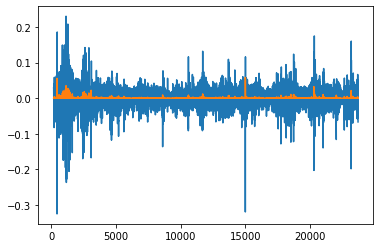

In [3]:
#Some Plotting to check variables
#plt.plot(dataset['log_value'])
#plt.plot(dataset['ma_3'])
#plt.plot(dataset['ma_20'])
plt.plot(dataset['lag_weekly_ret'])
plt.plot(dataset['ewma_var'])

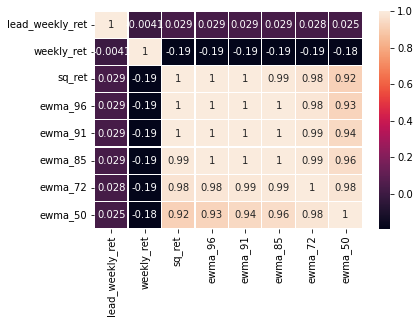

In [4]:
#Exponentially Weighted Variance 

ewma_set = pd.DataFrame(dataset['lead_weekly_ret'])
ewma_set['weekly_ret'] = dataset['lag_weekly_ret']
ewma_set['sq_ret'] = np.power(dataset['lag_weekly_ret'],2)
ewma_set['ewma_96'] = dataset['sq_ret'].ewm(alpha = 0.96).mean() #Uses the RiskMetrics 0.96 decay factor
ewma_set['ewma_91'] = dataset['sq_ret'].ewm(alpha = 0.91).mean()
ewma_set['ewma_85'] = dataset['sq_ret'].ewm(alpha = 0.85).mean()
ewma_set['ewma_72'] = dataset['sq_ret'].ewm(alpha = 0.72).mean()
ewma_set['ewma_50'] = dataset['sq_ret'].ewm(alpha = 0.5).mean()


ewma_set.head()
import seaborn as sn

corr_mat = ewma_set.corr()
sn.heatmap(corr_mat, annot=True, linewidths=.3)
plt.show()

In [5]:
#Signal Generation

#Momentum Rule
dataset['momentum_120'] = dataset['log_value'] - dataset['log_value'].shift(+200)
dataset['momentum_121'] = dataset['log_value'].shift(+20) - dataset['log_value'].shift(+200)
dataset['momentum_61'] = dataset['log_value'].shift(+20) - dataset['log_value'].shift(+100)

dataset['mom_120_rule'] = np.where(dataset['momentum_120']> 0, 1, 0)
dataset['mom_121_rule'] = np.where(dataset['momentum_121']> 0, 1, 0)
dataset['mom_61_rule'] = np.where(dataset['momentum_61']> 0, 1, 0)

#MA Change of Direction Rule

dataset['ma_200_cd_rule'] = np.where((dataset['sma_200']- dataset['sma_200'].shift(+1))>0,1,0)
dataset['ma_20_cd_rule'] = np.where((dataset['sma_20']- dataset['sma_20'].shift(+1))>0,1,0)

#PMA Rule

dataset['pma_20'] = dataset['log_value'] - dataset['sma_20']      
dataset['pma_100'] = dataset['log_value'] - dataset['sma_100']
dataset['pma_200'] = dataset['log_value'] - dataset['sma_200']

dataset['pma_20_rule'] = np.where(dataset['pma_20']>0, 1, 0)
dataset['pma_100_rule'] = np.where(dataset['pma_100']>0, 1, 0)
dataset['pma_200_rule'] = np.where(dataset['pma_200']>0, 1, 0)

#MA Crossover Rule

dataset['mac_3_10'] = dataset['sma_3'] - dataset['sma_10']
dataset['mac_50_200'] = dataset['sma_50'] - dataset['sma_200']

dataset['mac_3_10_rule'] = np.where(dataset['mac_3_10']>0, 1, 0)
dataset['mac_50_200_rule'] = np.where(dataset['mac_50_200']>0, 1, 0)

#Ma Convergence/Divergence Rule

dataset['mac_ema_50_200'] = dataset['ema_50'] - dataset['ema_200']

dataset['ema_mac_50_200'] = dataset['mac_ema_50_200'].ewm(alpha = 0.095).mean()

dataset['macd_50_200'] = dataset['mac_ema_50_200'] - dataset['ema_mac_50_200']

dataset['macd_50_200_rule'] = np.where(dataset['macd_50_200']>0, 1, 0)

In [6]:
rule_cols = [col for col in dataset.columns if 'rule' in col]

col_names = ['log_ret_class', 'lag_weekly_ret_class', 'ewma_var_ch']

#var_name = ['lead_ret_class']

var_name = ['lead_weekly_ret_class']

vars =  var_name + col_names + rule_cols

#var_name = ['lead_weekly_ret_class']

print(vars)

model_df = dataset[vars]

model_df.dropna(inplace = True)

model_df


['lead_weekly_ret_class', 'log_ret_class', 'lag_weekly_ret_class', 'ewma_var_ch', 'mom_120_rule', 'mom_121_rule', 'mom_61_rule', 'ma_200_cd_rule', 'ma_20_cd_rule', 'pma_20_rule', 'pma_100_rule', 'pma_200_rule', 'mac_3_10_rule', 'mac_50_200_rule', 'macd_50_200_rule']


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,lead_weekly_ret_class,log_ret_class,lag_weekly_ret_class,ewma_var_ch,mom_120_rule,mom_121_rule,mom_61_rule,ma_200_cd_rule,ma_20_cd_rule,pma_20_rule,pma_100_rule,pma_200_rule,mac_3_10_rule,mac_50_200_rule,macd_50_200_rule
199,1,1,1,0.000236,0,0,0,0,0,1,1,1,1,1,0
200,1,1,1,0.000140,0,0,0,1,1,1,1,1,1,1,1
201,1,1,1,-0.000081,0,0,0,1,1,1,1,1,1,1,1
202,0,1,1,-0.000035,0,0,0,1,1,1,1,1,1,1,1
203,1,0,1,-0.000171,0,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,0,0,1,-0.000062,1,1,0,1,0,0,0,0,0,0,0
23690,0,0,0,-0.000058,1,1,0,1,0,0,0,0,1,0,0
23691,0,0,0,0.000219,0,1,0,0,0,0,0,0,0,0,0
23692,0,1,0,0.000014,0,1,0,0,0,0,0,0,0,0,0


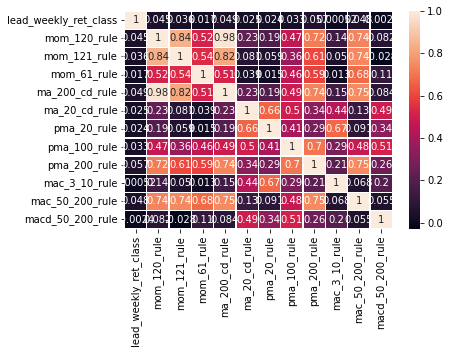

In [7]:
#Correlation Matrix

import seaborn as sn

vars_corr = var_name + rule_cols

corr_mat = model_df[vars_corr].corr()
sn.heatmap(corr_mat, annot=True, linewidths=.3)
plt.show()

In [63]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

#prepare Train-Test-Validate Dataset

steps = 20

ts = 0.1

values = model_df.values

# Creating a data structure with i time-steps and 1 output
X = []
y = []

for i in range(steps, len(values)):
    X.append(values[i-steps:i, 1:])
    y.append(values[i, 0])

X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

y = np.reshape(y, (y.shape[0],1))

# Creating a data structure with i time-steps and 1 output
train_X = []
train_y = []

test_X = []
test_y = []

validation_X = []
validation_y = []

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

train_X, validation_X, train_y, validation_y = train_test_split(train_X, train_y, test_size= ts, random_state=1) # 0.02 x 0.8 = 0.016

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, validation_X.shape, validation_y.shape)

(16875, 20, 14) (16875, 1) (4688, 20, 14) (4688, 1) (1875, 20, 14) (1875, 1)


In [8]:
#prepare Train-Test-Validate Dataset 2
# Import train_test_split function
from sklearn.model_selection import train_test_split

steps = 200

validation_len = 254 #1 year backtest

test_size = 0.2

values = model_df.values

# Creating a data structure with i time-steps and 1 output
X = []
y = []

for i in range(steps, len(values)):
    X.append(values[i-steps:i, 1:])
    y.append(values[i, 0])

X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

y = np.reshape(y, (y.shape[0],1))

# Creating a data structure with i time-steps and 1 output
train_X = []
train_y = []

test_X = []
test_y = []

validation_X = X[len(X) - validation_len:,:,:]
validation_y = y[len(y) - validation_len:,:]

train_X, test_X, train_y, test_y = train_test_split(X[0:len(X) - validation_len,:,:], y[0:len(y) - validation_len,:], test_size= test_size, random_state=1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, validation_X.shape, validation_y.shape)

np.random.seed(1234)

(18432, 200, 14) (18432, 1) (4609, 200, 14) (4609, 1) (254, 200, 14) (254, 1)


In [ ]:
#Other Train Dev Test Set, with week ahead class and using last year as validation to see effects from Overfitting

In [ ]:
train_y

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

Epoch 1/100
576/576 - 24s - loss: 0.6867 - accuracy: 0.5598 - val_loss: 0.6870 - val_accuracy: 0.5513 - 24s/epoch - 42ms/step
Epoch 2/100
576/576 - 14s - loss: 0.6849 - accuracy: 0.5628 - val_loss: 0.6863 - val_accuracy: 0.5541 - 14s/epoch - 25ms/step
Epoch 3/100
576/576 - 14s - loss: 0.6838 - accuracy: 0.5641 - val_loss: 0.6856 - val_accuracy: 0.5570 - 14s/epoch - 25ms/step
Epoch 4/100
576/576 - 14s - loss: 0.6827 - accuracy: 0.5654 - val_loss: 0.6833 - val_accuracy: 0.5604 - 14s/epoch - 25ms/step
Epoch 5/100
576/576 - 14s - loss: 0.6812 - accuracy: 0.5685 - val_loss: 0.6839 - val_accuracy: 0.5589 - 14s/epoch - 25ms/step
Epoch 6/100
576/576 - 15s - loss: 0.6799 - accuracy: 0.5711 - val_loss: 0.6810 - val_accuracy: 0.5706 - 15s/epoch - 26ms/step
Epoch 7/100
576/576 - 14s - loss: 0.6774 - accuracy: 0.5752 - val_loss: 0.6791 - val_accuracy: 0.5765 - 14s/epoch - 25ms/step
Epoch 8/100
576/576 - 14s - loss: 0.6749 - accuracy: 0.5790 - val_loss: 0.6778 - val_accuracy: 0.5787 - 14s/epoch - 25

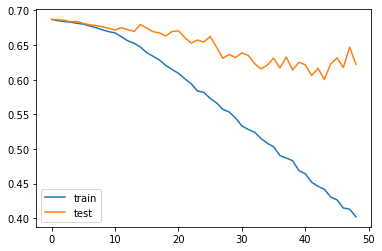

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience = 5, min_delta=0.001)

model = Sequential()

model.add(LSTM(100, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history = model.fit(train_X, train_y, epochs = 100, batch_size=32, validation_data = (test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

yhat = (model.predict(test_X) > 0.5).astype("int32")

yhat = yhat.reshape(yhat.shape[0],yhat.shape[1])

test_y = test_y.reshape(test_y.shape[0],1)

print(confusion_matrix(pd.DataFrame(test_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0]))
#print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
#print(classification_report(pd.DataFrame(test_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0], target_names = ['1', '0']))
print(classification_report(pd.DataFrame(test_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0]))


#print(yhat, validation_y)

[[1300  770]
 [ 483 2056]]
              precision    recall  f1-score   support

         0.0       0.73      0.63      0.67      2070
         1.0       0.73      0.81      0.77      2539

    accuracy                           0.73      4609
   macro avg       0.73      0.72      0.72      4609
weighted avg       0.73      0.73      0.73      4609



In [11]:
#Import Random Forest and Train_Test Split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

train_rf_X = train_X[:,0,1:]

test_rf_X = test_X[:,0,1:]

train_rf_y = train_y[:,0]

test_rf_y = test_y[:,0]

#validation_rf_X = validation_X[:,0,1:]

#validation_rf_y = validation_y[:,0,0]

print(train_rf_X.shape, train_rf_y.shape, test_rf_X.shape, test_rf_y.shape)

#, test_rf_X, train_rf_y, test_rf_y = 

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_rf_X,train_rf_y)

y_pred = clf.predict(test_rf_X)

#y_val = clf.predict(validation_rf_X)

from sklearn import metrics

#test metrics

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0]))

#validation metrics
#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))


(18432, 13) (18432,) (4609, 13) (4609,)
[[ 927 1143]
 [1072 1467]]
              precision    recall  f1-score   support

         0.0       0.46      0.45      0.46      2070
         1.0       0.56      0.58      0.57      2539

    accuracy                           0.52      4609
   macro avg       0.51      0.51      0.51      4609
weighted avg       0.52      0.52      0.52      4609



In [12]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,max_depth=1, random_state=1)

clf_gb.fit(train_rf_X,train_rf_y)

y_gb_pred = clf_gb.predict(test_rf_X)

#y_val = clf_gb.predict(validation_rf_X)

#test metrics

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_gb_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_gb_pred).iloc[:,0]))

#validation metrics

#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))




[[  56 2014]
 [  66 2473]]
              precision    recall  f1-score   support

         0.0       0.46      0.03      0.05      2070
         1.0       0.55      0.97      0.70      2539

    accuracy                           0.55      4609
   macro avg       0.51      0.50      0.38      4609
weighted avg       0.51      0.55      0.41      4609



In [13]:
from sklearn.ensemble import AdaBoostClassifier

clf_ab = AdaBoostClassifier(n_estimators=100, learning_rate=0.5,random_state=1)

clf_ab.fit(train_rf_X,train_rf_y)

y_ab_pred = clf_ab.predict(test_rf_X)

#y_val = clf_gb.predict(validation_rf_X)

#test metrics

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_ab_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_ab_pred).iloc[:,0]))


[[  58 2012]
 [  66 2473]]
              precision    recall  f1-score   support

         0.0       0.47      0.03      0.05      2070
         1.0       0.55      0.97      0.70      2539

    accuracy                           0.55      4609
   macro avg       0.51      0.50      0.38      4609
weighted avg       0.51      0.55      0.41      4609



In [14]:
from sklearn import svm

clf_svm = svm.NuSVC(gamma="auto")

clf_svm.fit(train_rf_X,train_rf_y)

y_svm_pred = clf_svm.predict(test_rf_X)

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_svm_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_svm_pred).iloc[:,0]))


[[1009 1061]
 [1199 1340]]
              precision    recall  f1-score   support

         0.0       0.46      0.49      0.47      2070
         1.0       0.56      0.53      0.54      2539

    accuracy                           0.51      4609
   macro avg       0.51      0.51      0.51      4609
weighted avg       0.51      0.51      0.51      4609



In [15]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state = 1, penalty = 'l2')

clf_lr.fit(train_rf_X,train_rf_y)

y_lr_pred = clf_lr.predict(test_rf_X)

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_lr_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_lr_pred).iloc[:,0]))

[[   9 2061]
 [  25 2514]]
              precision    recall  f1-score   support

         0.0       0.26      0.00      0.01      2070
         1.0       0.55      0.99      0.71      2539

    accuracy                           0.55      4609
   macro avg       0.41      0.50      0.36      4609
weighted avg       0.42      0.55      0.39      4609



Epoch 1/100
576/576 - 2s - loss: 0.6880 - accuracy: 0.5584 - val_loss: 0.6877 - val_accuracy: 0.5509 - 2s/epoch - 4ms/step
Epoch 2/100
576/576 - 1s - loss: 0.6863 - accuracy: 0.5607 - val_loss: 0.6880 - val_accuracy: 0.5509 - 1s/epoch - 2ms/step
Epoch 3/100
576/576 - 1s - loss: 0.6860 - accuracy: 0.5608 - val_loss: 0.6876 - val_accuracy: 0.5509 - 1s/epoch - 2ms/step
Epoch 4/100
576/576 - 1s - loss: 0.6852 - accuracy: 0.5625 - val_loss: 0.6877 - val_accuracy: 0.5509 - 1s/epoch - 2ms/step
Epoch 5/100
576/576 - 1s - loss: 0.6855 - accuracy: 0.5621 - val_loss: 0.6872 - val_accuracy: 0.5509 - 1s/epoch - 2ms/step
Epoch 6/100
576/576 - 1s - loss: 0.6852 - accuracy: 0.5618 - val_loss: 0.6874 - val_accuracy: 0.5509 - 1s/epoch - 2ms/step
Epoch 7/100
576/576 - 1s - loss: 0.6848 - accuracy: 0.5636 - val_loss: 0.6873 - val_accuracy: 0.5509 - 1s/epoch - 2ms/step
Epoch 8/100
576/576 - 1s - loss: 0.6847 - accuracy: 0.5622 - val_loss: 0.6875 - val_accuracy: 0.5509 - 1s/epoch - 3ms/step
Epoch 9/100
576/

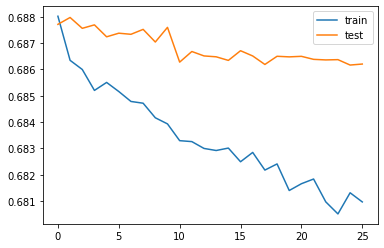

In [18]:
#from tensorflow.keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

model_mlp = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience = 15, min_delta=0.001)

#train_rf_X = np.reshape(train_rf_X, (train_rf_X.shape[0], train_rf_X.shape[1], train_rf_X.shape[2]))

#train_rf_y = np.reshape(train_rf_y, (train_rf_y.shape[0],1))

model_mlp.add(Dense(100, input_shape=(train_rf_X.shape[1],), activation = 'relu'))
model_mlp.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model_mlp.add(Dense(100, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(100, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(100, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(100, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model_mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history_mlp = model_mlp.fit(train_rf_X, train_rf_y, epochs = 100, batch_size=32, validation_data = (test_rf_X, test_rf_y), verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history_mlp.history['loss'], label='train')
plt.plot(history_mlp.history['val_loss'], label='test')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

yhat_mlp = (model_mlp.predict(test_rf_X) > 0.5).astype("int32")

yhat_mlp = yhat_mlp.reshape(yhat_mlp.shape[0],yhat_mlp.shape[1])

test_rf_y = test_rf_y.reshape(test_rf_y.shape[0],1)

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(yhat_mlp).iloc[:,0]))
#print('Classification Report')

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(yhat_mlp).iloc[:,0]))

#print(yhat, validation_y)

[[  32 2038]
 [  15 2524]]
              precision    recall  f1-score   support

         0.0       0.68      0.02      0.03      2070
         1.0       0.55      0.99      0.71      2539

    accuracy                           0.55      4609
   macro avg       0.62      0.50      0.37      4609
weighted avg       0.61      0.55      0.41      4609



In [20]:
# Model 2 Development

validation_rf_X = validation_X[:,0,1:]

validation_rf_y = validation_y[:,0]

print(validation_rf_X.shape, validation_rf_y.shape)

#LSTM
yhat_test = (model.predict(validation_X) > 0.5).astype("int32")

yhat_test = yhat_test.reshape(yhat_test.shape[0],yhat_test.shape[1])

validation_y = validation_y.reshape(validation_y.shape[0],1)

#Random Forest

y_pred_test = clf.predict(validation_rf_X)

#Gradient Boosting

y_gb_pred_test = clf_gb.predict(validation_rf_X)

#Gradient Boosting

y_ab_pred_test = clf_ab.predict(validation_rf_X)

#Support Vector Classifier

y_svm_pred_test = clf_svm.predict(validation_rf_X)

#Logistic Regression

y_lr_pred_test = clf_lr.predict(validation_rf_X)

#Multi Layer Perceptron

y_mlp_pred_test = (model_mlp.predict(validation_rf_X) > 0.5).astype("int32")

print(y_mlp_pred_test.shape)

y_mlp_pred_test = y_mlp_pred_test.reshape(y_mlp_pred_test.shape[0],y_mlp_pred_test.shape[1])


(254, 13) (254,)
(254, 1)


In [21]:
print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(yhat_test).iloc[:,0]))

print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(yhat_test).iloc[:,0]))


[[52 60]
 [51 91]]
              precision    recall  f1-score   support

         0.0       0.50      0.46      0.48       112
         1.0       0.60      0.64      0.62       142

    accuracy                           0.56       254
   macro avg       0.55      0.55      0.55       254
weighted avg       0.56      0.56      0.56       254



In [22]:
#Model 2 Train Set

model_stack = pd.DataFrame(yhat, columns = ['lstm'])

model_stack['mlp'] = yhat_mlp

model_stack['randomForest'] = y_pred

model_stack['GradientBoosting'] = y_gb_pred

model_stack['AdaBoost'] = y_ab_pred

model_stack['svm'] = y_svm_pred

model_stack['logReg'] = y_lr_pred

X_stack = np.concatenate((model_stack.values,test_rf_X),axis=1)

print(X_stack.shape)


(4609, 20)


In [23]:
#Model 2 Train Set

model_test_stack = pd.DataFrame(yhat_test, columns = ['lstm'])

model_test_stack['mlp'] = y_mlp_pred_test

model_test_stack['randomForest'] = y_pred_test

model_test_stack['GradientBoosting'] = y_gb_pred_test

model_test_stack['AdaBoost'] = y_ab_pred_test

model_test_stack['svm'] = y_svm_pred_test

model_test_stack['logReg'] = y_lr_pred_test

X_test_stack = np.concatenate((model_test_stack.values,validation_rf_X),axis=1)

In [36]:
X_test_stack.shape

(376, 19)

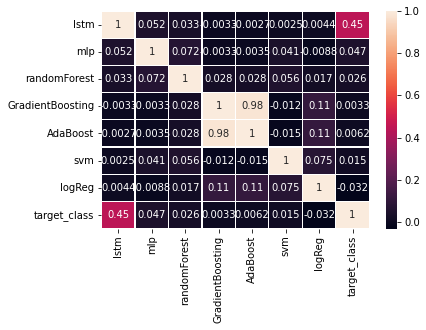

In [24]:
#Correlation Matrix

import seaborn as sn

model_corr = model_stack

model_corr['target_class'] = test_rf_y

corr_mat = model_corr.corr()
sn.heatmap(corr_mat, annot=True, linewidths=.3)
plt.show()

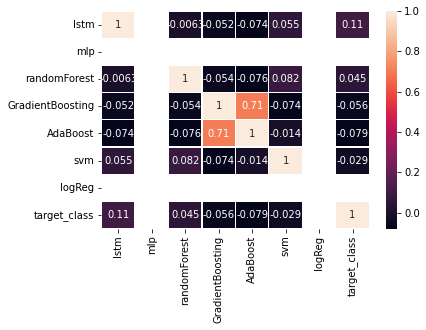

In [25]:
#Correlation Matrix

import seaborn as sn

model_corr = model_test_stack

model_corr['target_class'] = validation_rf_y

corr_mat = model_corr.corr()
sn.heatmap(corr_mat, annot=True, linewidths=.3)
plt.show()

In [78]:
model_test_stack.head()

,lstm,mlp,randomForest,GradientBoosting,svm,logReg,target_class
0,1,1,1.0,1.0,0.0,1.0,1.0
1,0,1,1.0,1.0,0.0,1.0,1.0
2,0,1,0.0,1.0,0.0,1.0,1.0
3,0,1,0.0,1.0,0.0,1.0,1.0
4,0,1,1.0,1.0,0.0,1.0,1.0


Epoch 1/100
145/145 - 1s - loss: 0.6651 - accuracy: 0.6016 - val_loss: 0.7386 - val_accuracy: 0.5630 - 1s/epoch - 10ms/step
Epoch 2/100
145/145 - 0s - loss: 0.6167 - accuracy: 0.7006 - val_loss: 0.7513 - val_accuracy: 0.5630 - 500ms/epoch - 3ms/step
Epoch 3/100
145/145 - 0s - loss: 0.6054 - accuracy: 0.7232 - val_loss: 0.7420 - val_accuracy: 0.5630 - 469ms/epoch - 3ms/step
Epoch 4/100
145/145 - 1s - loss: 0.6043 - accuracy: 0.7212 - val_loss: 0.7319 - val_accuracy: 0.5630 - 514ms/epoch - 4ms/step
Epoch 5/100
145/145 - 0s - loss: 0.6008 - accuracy: 0.7232 - val_loss: 0.7274 - val_accuracy: 0.5630 - 456ms/epoch - 3ms/step
Epoch 6/100
145/145 - 0s - loss: 0.5946 - accuracy: 0.7245 - val_loss: 0.7275 - val_accuracy: 0.5630 - 401ms/epoch - 3ms/step
Epoch 7/100
145/145 - 0s - loss: 0.5913 - accuracy: 0.7253 - val_loss: 0.7304 - val_accuracy: 0.5630 - 397ms/epoch - 3ms/step
Epoch 8/100
145/145 - 0s - loss: 0.5902 - accuracy: 0.7251 - val_loss: 0.7284 - val_accuracy: 0.5630 - 399ms/epoch - 3ms

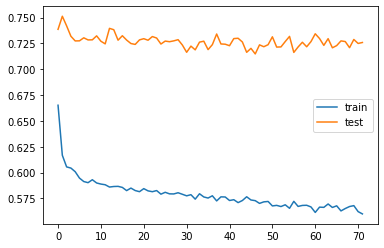

In [26]:
neurons = 100

model_stacked = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience = 25, min_delta=0.001)

#train_rf_X = np.reshape(train_rf_X, (train_rf_X.shape[0], train_rf_X.shape[1], train_rf_X.shape[2]))

#train_rf_y = np.reshape(train_rf_y, (train_rf_y.shape[0],1))

model_stacked.add(Dense(neurons, input_shape=(X_stack.shape[1],), activation = 'relu'))
model_stacked.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model_stacked.add(Dense(neurons, activation = 'relu'))
model_stacked.add(Dropout(0.3))

model_stacked.add(Dense(neurons, activation = 'relu'))
model_stacked.add(Dropout(0.3))

model_stacked.add(Dense(neurons, activation = 'relu'))
model_stacked.add(Dropout(0.3))

model_stacked.add(Dense(neurons, activation = 'relu'))
model_stacked.add(Dropout(0.3))

model_stacked.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model_stacked.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history_stacked = model_stacked.fit(X_stack, test_rf_y, epochs = 100, batch_size=32, validation_data = (X_test_stack, validation_rf_y), verbose=2, shuffle=False, callbacks=[early_stopping])
#history_stacked = model_stacked.fit(X_stack, test_rf_y, epochs = 50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history_stacked.history['loss'], label='train')
plt.plot(history_stacked.history['val_loss'], label='test')
plt.legend()
plt.show()

In [27]:
#MLP as Stacking Algorithm Prediction

stk_mlp_pred = (model_stacked.predict(X_test_stack) > 0.5).astype("int32")

stk_mlp_pred = stk_mlp_pred.reshape(stk_mlp_pred.shape[0],stk_mlp_pred.shape[1])

validation_rf_y = validation_rf_y.reshape(validation_rf_y.shape[0],1)

print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(stk_mlp_pred).iloc[:,0]))
#print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(stk_mlp_pred).iloc[:,0]))

#print(yhat, validation_y)

[[52 60]
 [51 91]]
              precision    recall  f1-score   support

         0.0       0.50      0.46      0.48       112
         1.0       0.60      0.64      0.62       142

    accuracy                           0.56       254
   macro avg       0.55      0.55      0.55       254
weighted avg       0.56      0.56      0.56       254



In [28]:
#Gradient Boosting as Stacking Algorithm

stk_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)

stk_gb.fit(X_stack, test_rf_y)

stck_gb_pred = stk_gb.predict(X_test_stack)

#y_val = clf_gb.predict(validation_rf_X)

#test metrics

#print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_gb_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(stck_gb_pred).iloc[:,0]))

#validation metrics

#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))





/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0       0.50      0.46      0.48       112
         1.0       0.60      0.64      0.62       142

    accuracy                           0.56       254
   macro avg       0.55      0.55      0.55       254
weighted avg       0.56      0.56      0.56       254



In [87]:
# Logistic Regression as Stacking Classifier


stk_lr = LogisticRegression(random_state = 1, penalty = 'l2')

stk_lr.fit(X_stack, test_rf_y)

stk_lr_pred = stk_lr.predict(X_test_stack)

#print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_lr_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(stk_lr_pred).iloc[:,0]))

              precision    recall  f1-score   support

         0.0       0.43      0.56      0.49        82
         1.0       0.62      0.49      0.55       118

    accuracy                           0.52       200
   macro avg       0.53      0.53      0.52       200
weighted avg       0.54      0.52      0.52       200



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


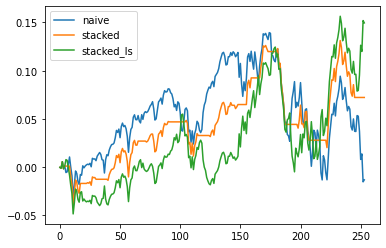

In [31]:
model_bt = pd.DataFrame(validation_rf_y, columns = ['lead_ret_class'])

#model_bt['lead_weekly_ret'] = dataset.iloc[4,len(dataset) - validation_len:]

temp = dataset['lead_ret']

model_bt['lead_ret'] = temp[len(temp) - validation_len:].to_numpy()

model_bt['stacked'] = stk_mlp_pred

model_bt['stacked_ls'] = np.where((model_bt.stacked == 1), 1, -1)

model_bt['naive'] = np.ones(len(stk_mlp_pred))

model_bt['naive_logRet'] = model_bt['naive'] * model_bt['lead_ret']

model_bt['stacked_logRet'] = model_bt['stacked'] * model_bt['lead_ret']

model_bt['stacked_ls_logRet'] = model_bt['stacked_ls'] * model_bt['lead_ret']

model_bt['naive_cumRet'] = (1 + model_bt['naive_logRet']).cumprod() - 1 

model_bt['stacked_cumRet'] = (1 + model_bt['stacked_logRet']).cumprod() - 1 

model_bt['stacked_ls_cumRet'] = (1 + model_bt['stacked_ls_logRet']).cumprod() - 1 
#model_bt.head()

#dataset['lead_weekly_ret']

#temp[len(temp) - validation_len:]

#print(temp[len(temp) - validation_len:])

model_bt.head()

plt.plot(model_bt['naive_cumRet'], label = 'naive')
plt.plot(model_bt['stacked_cumRet'], label = 'stacked')
plt.plot(model_bt['stacked_ls_cumRet'], label = 'stacked_ls')
plt.legend()
plt.show()



In [136]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
history_stacked.save('saved_model/my_model') 

AttributeError: ignored

In [133]:
#performance statistics

sd_df = model_bt.std()



ret_df = model_bt.iloc[-1:]
print(sd_df, ret_df)



lead_ret_class       0.493068
lead_ret             0.008991
stacked              0.497001
stacked_ls           0.994002
naive                0.000000
naive_logRet         0.008991
stacked_logRet       0.006951
stacked_ls_logRet    0.008926
naive_cumRet         0.038435
stacked_cumRet       0.044315
stacked_ls_cumRet    0.065669
dtype: float64      lead_ret_class  lead_ret  stacked  stacked_ls  naive  naive_logRet  \
199             0.0 -0.007966      1.0           1    1.0     -0.007966   

     stacked_logRet  stacked_ls_logRet  naive_cumRet  stacked_cumRet  \
199       -0.007966          -0.007966      0.043357        0.139749   

     stacked_ls_cumRet  
199           0.237113  
